1. Setup Environment

In [2]:
# Install YOLO dependencies
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00


In [3]:
import os
import time
import torch
import shutil
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO
from google.colab import files


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


2. Upload Local Dataset & Models

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
# Define dataset extraction path
dataset_zip_path = "/content/drive/MyDrive/ready_labeled_helmet_vest_dataset.zip"
dataset_extract_path = "/content/helmet_vest_dataset"

# Extract dataset
with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_extract_path)


# Upload YOLO models manually
uploaded_models = files.upload()  # Select "yolov8m.pt" and "yolov11m.pt"



Saving helmet_vest_yolov8m.pt to helmet_vest_yolov8m.pt
Saving helmet_vest_yolo11m.pt to helmet_vest_yolo11m.pt


In [27]:
# Define paths
yolo8m_model_path = "/content/helmet_vest_yolov8m.pt"
yolo11m_model_path = "/content/helmet_vest_yolo11m.pt"
dataset_yaml_path = "/content/helmet_vest_dataset/ready_labeled_helmet_vest_dataset/data.yaml"

model_yolo8m = YOLO(yolo8m_model_path)
model_yolo11m = YOLO(yolo11m_model_path)

# Define input sizes to test
input_sizes = [640, 320]

# Store results
results_list = []


3. Extract Metrics Function

In [28]:
def extract_metrics(results, model_name, model_path, img_size):
    return {
        "Model": model_name,
        "Input Size": img_size,  # ✅ Include input size
        "mAP50": results.results_dict.get('metrics/mAP50(B)', 0) * 100,
        "mAP50-95": results.results_dict.get('metrics/mAP50-95(B)', 0) * 100,
        "Precision": results.results_dict.get('metrics/precision(B)', 0) * 100,
        "Recall": results.results_dict.get('metrics/recall(B)', 0) * 100,
        "F1-Score": (2 * results.results_dict.get('metrics/precision(B)', 0) * results.results_dict.get('metrics/recall(B)', 0)) / \
                    (results.results_dict.get('metrics/precision(B)', 0) + results.results_dict.get('metrics/recall(B)', 0) + 1e-6) * 100,
        "Inference Time (ms)": results.speed.get('inference', 0),
        "Model Size (MB)": os.path.getsize(model_path) / (1024 * 1024)
    }

4. Evaluate the model

In [29]:
# Run validation for each input size
for img_size in input_sizes:
    print(f"Validating YOLOv8m at {img_size}x{img_size} resolution...")
    results_yolo8m = model_yolo8m.val(data=dataset_yaml_path, imgsz=img_size)
    results_list.append(extract_metrics(results_yolo8m, "YOLOv8m", yolo8m_model_path, img_size))  # ✅ Fixed

    print(f"Validating YOLOv11m at {img_size}x{img_size} resolution...")
    results_yolo11m = model_yolo11m.val(data=dataset_yaml_path, imgsz=img_size)
    results_list.append(extract_metrics(results_yolo11m, "YOLOv11m", yolo11m_model_path, img_size))  # ✅ Fixed

# Convert results to DataFrame
comparison_df = pd.DataFrame(results_list)

# Save results
comparison_df.to_csv("yolo_comparison_results_640_320.csv", index=False)

Validating YOLOv8m at 640x640 resolution...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


val: Scanning /content/helmet_vest_dataset/ready_labeled_helmet_vest_dataset/labels/val.cache... 6203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6203/6203 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 388/388 [00:37<00:00, 10.28it/s]


                   all       6203      19499      0.942      0.862      0.919      0.664
         Safety Helmet       4343      16086      0.962      0.844      0.908      0.648
           Safety Vest       1860       3413      0.921       0.88       0.93      0.679
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val8
Validating YOLOv11m at 640x640 resolution...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLO11m summary (fused): 125 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /content/helmet_vest_dataset/ready_labeled_helmet_vest_dataset/labels/val.cache... 6203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6203/6203 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 388/388 [00:38<00:00,  9.98it/s]


                   all       6203      19499      0.939      0.863      0.919      0.663
         Safety Helmet       4343      16086       0.96      0.849      0.909      0.646
           Safety Vest       1860       3413      0.918      0.878       0.93       0.68
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val9
Validating YOLOv8m at 320x320 resolution...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/helmet_vest_dataset/ready_labeled_helmet_vest_dataset/labels/val.cache... 6203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6203/6203 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 388/388 [00:29<00:00, 13.16it/s]


                   all       6203      19499      0.932      0.819      0.879      0.603
         Safety Helmet       4343      16086      0.949      0.779      0.851      0.578
           Safety Vest       1860       3413      0.915       0.86      0.906      0.628
Speed: 0.0ms preprocess, 1.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val10
Validating YOLOv11m at 320x320 resolution...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)


val: Scanning /content/helmet_vest_dataset/ready_labeled_helmet_vest_dataset/labels/val.cache... 6203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6203/6203 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 388/388 [00:30<00:00, 12.88it/s]


                   all       6203      19499      0.924       0.82      0.878      0.603
         Safety Helmet       4343      16086      0.945      0.784      0.856      0.581
           Safety Vest       1860       3413      0.903      0.856      0.899      0.625
Speed: 0.0ms preprocess, 1.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val11


5. Plot Metrics

In [30]:
# Display results
from IPython.display import display
display(comparison_df)

,Model,Input Size,mAP50,mAP50-95,Precision,Recall,F1-Score,Inference Time (ms),Model Size (MB)
0,YOLOv8m,640,91.901322,66.358764,94.163463,86.179337,89.994614,2.169583,49.611278
1,YOLOv11m,640,91.933984,66.274151,93.888522,86.348320,89.960649,2.409280,38.620030
2,YOLOv8m,320,87.860558,60.321393,93.188866,81.938057,87.202015,1.005517,49.611278
3,YOLOv11m,320,87.768032,60.337352,92.400624,82.000746,86.890553,1.137418,38.620030


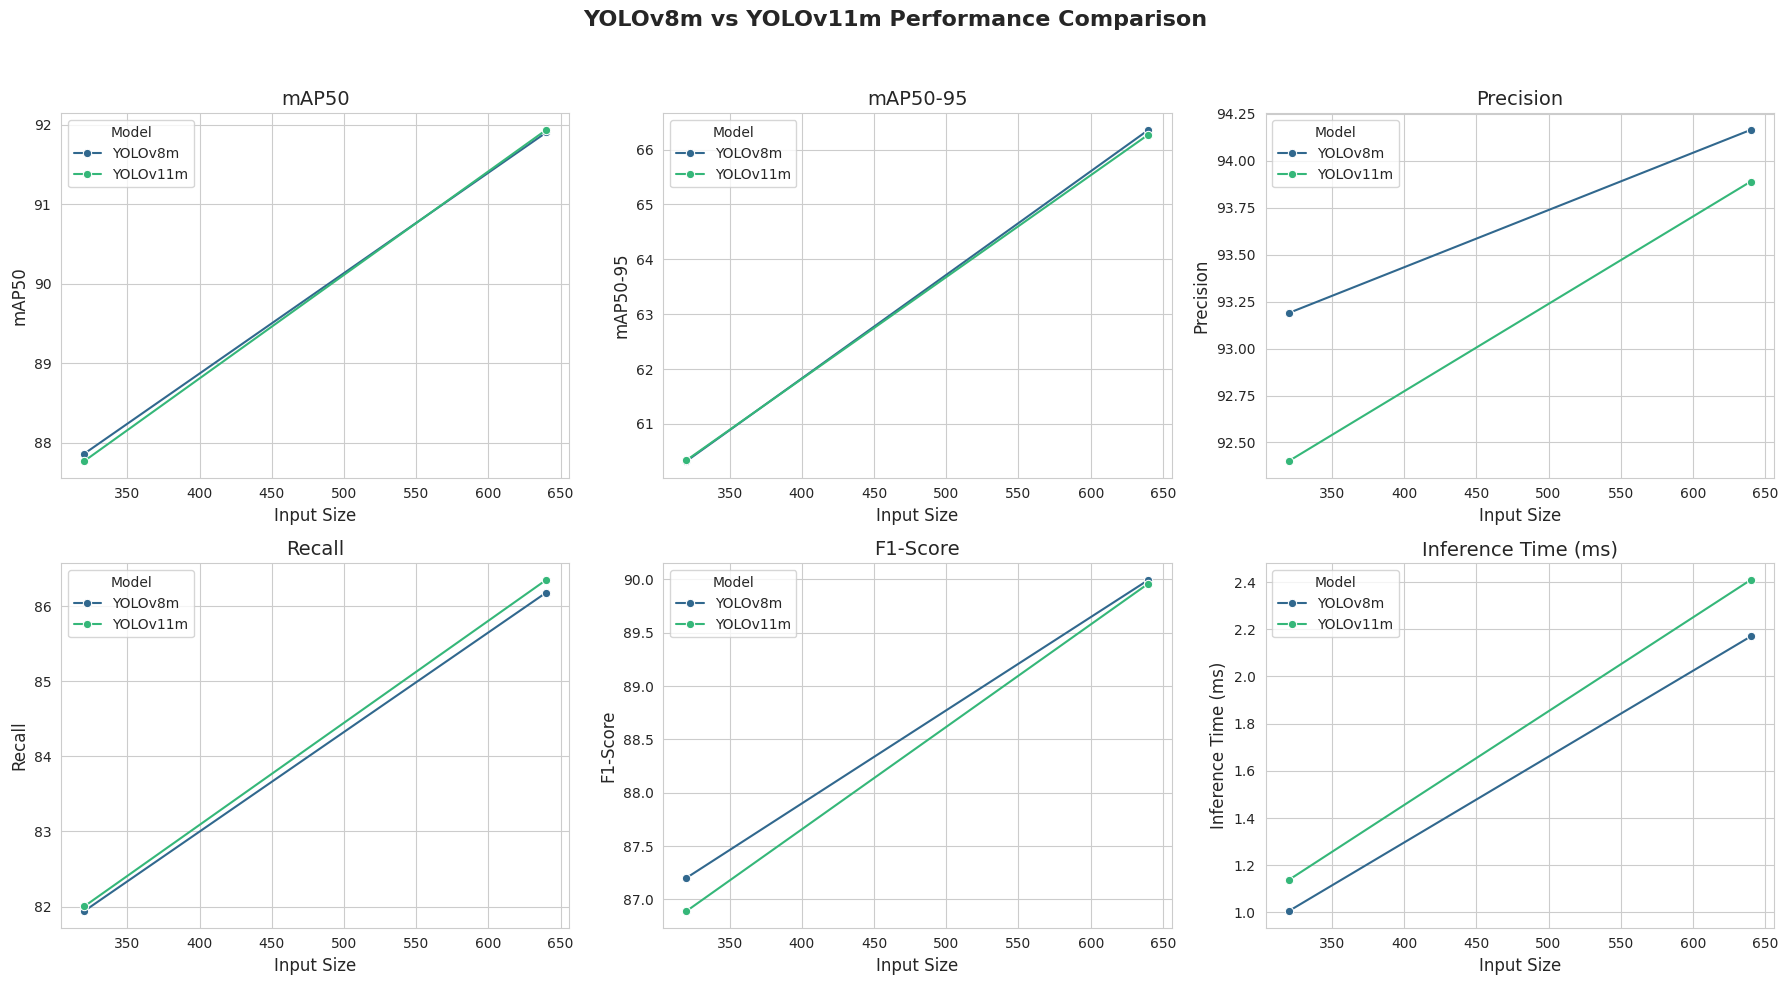

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the comparison results from CSV
comparison_df = pd.read_csv("yolo_comparison_results_640_320.csv")

# Ensure Input Size column exists
if "Input Size" not in comparison_df.columns:
    print("Error: 'Input Size' column not found in CSV.")
else:
    # Define the metrics to plot
    metrics = ["mAP50", "mAP50-95", "Precision", "Recall", "F1-Score", "Inference Time (ms)"]

    # Set Seaborn style for better visualization
    sns.set_style("whitegrid")

    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()

    # Plot each metric
    for i, metric in enumerate(metrics):
        ax = axes[i]
        sns.lineplot(
            data=comparison_df,
            x="Input Size",
            y=metric,
            hue="Model",
            marker="o",
            ax=ax,
            palette="viridis"
        )
        ax.set_title(metric, fontsize=14)
        ax.set_xlabel("Input Size", fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(title="Model", fontsize=10)

    # Adjust layout for better spacing
    plt.suptitle("YOLOv8m vs YOLOv11m Performance Comparison", fontsize=16, fontweight="bold")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    plt.show()
